In [1]:
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split

In [2]:
#read train data, validate data and test data
train_data = pd.read_csv("train_data.csv",header=0)
val_data = pd.read_csv("validate_data.csv",header=0)
test_data = pd.read_csv("test_data.csv",header=0)

#train data
X_train = train_data[["actor_rating", "director_rating", "genre_rating", "language_rating","region_rating", "writer_rating", "date"]].values
y_train = train_data[["movie_rating"]].values

#validation data
X_val = val_data[["actor_rating", "director_rating", "genre_rating", "language_rating","region_rating", "writer_rating", "date"]].values
y_val = val_data[["movie_rating"]].values

#test data
X_test = test_data[["actor_rating", "director_rating", "genre_rating", "language_rating","region_rating", "writer_rating", "date"]].values
y_test = test_data[["movie_rating"]].values

In [3]:
#<Zihan Dai> (<2020/11>) <ridge_regression> [<.ipynb>]. Machine learning course Assignment2.
class RidgeRegression(BaseEstimator, RegressorMixin):
    """ ridge regression"""

    def __init__(self, l2reg=1):
        if l2reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2reg = l2reg

    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        def ridge_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2) / n
            l2_norm_squared = np.sum(w**2)
            objective = empirical_risk + self.l2reg * l2_norm_squared
            return objective
        self.ridge_obj_ = ridge_obj

        w_0 = np.zeros(num_ftrs)
        self.w_ = minimize(ridge_obj, w_0).x
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)


def do_grid_search_ridge(X_train, y_train, X_val, y_val):
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation、
    
    param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-2.5,-1.5,0.005),)))}]
    
    ridge_regression_estimator = RidgeRegression()
    grid = GridSearchCV(ridge_regression_estimator,
                        param_grid,
                        return_train_score=True,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                              greater_is_better = False))
    grid.fit(X_train_val, y_train_val)
    df = pd.DataFrame(grid.cv_results_)
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l2reg"])
    return grid, df_toshow

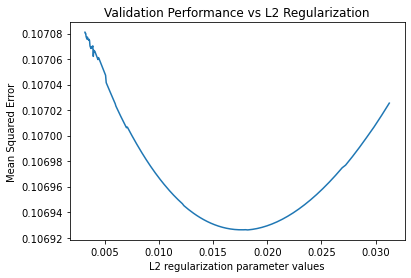

,param_l2reg,mean_test_score,mean_train_score
0,0.003162,0.107081,0.115249
1,0.003199,0.107080,0.115249
2,0.003236,0.107080,0.115249
3,0.003273,0.107078,0.115250
4,0.003311,0.107077,0.115250
...,...,...,...
195,0.029854,0.107007,0.115732
196,0.030200,0.107011,0.115741
197,0.030549,0.107016,0.115750
198,0.030903,0.107021,0.115760


In [4]:
#<Zihan Dai> (<2020/11>) <ridge_regression> [<.ipynb>]. Machine learning course Assignment2.
#Run ridge regression on the provided training dataset.  Choose the λ that minimizes
#the empirical risk (i.e.  the average square loss) on the validation set.
grid,df_toshow=do_grid_search_ridge(X_train, y_train, X_val, y_val)

plt.plot(df_toshow['param_l2reg'],df_toshow['mean_test_score'])
plt.title("Validation Performance vs L2 Regularization")
plt.ylabel('Mean Squared Error')
plt.xlabel('L2 regularization parameter values')
plt.show()

df_toshow

Choose λ = 0.017

In [5]:
#compute linear regression MSE of validation set
l2reg = 0
ridge_regression_estimator = RidgeRegression(l2reg)
ridge_regression_estimator.fit(X_train, y_train)
y_val_pred = ridge_regression_estimator.predict(X_val)
MSE = 0
for i in range(len(y_val_pred)):
    MSE += (y_val_pred[i]-y_val[i][0])**2
MSE /= len(y_val_pred)
print("MSE of linear regression =",MSE)

MSE of linear regression = 0.10716584394669013


In [6]:
#compute ridge regression MSE of validation set
l2reg = 0.017
ridge_regression_estimator = RidgeRegression(l2reg)
ridge_regression_estimator.fit(X_train, y_train)
y_val_pred = ridge_regression_estimator.predict(X_val)
MSE = 0
for i in range(len(y_val_pred)):
    MSE += (y_val_pred[i]-y_val[i][0])**2
MSE /= len(y_val_pred)
print("MSE of ridge regression =",MSE)

MSE of ridge regression = 0.10692640417735948


In [7]:
#regular linear regression (λ=0)

#train model
l2reg = 0
ridge_regression_estimator = RidgeRegression(l2reg)
ridge_regression_estimator.fit(X_train, y_train)
y_pred = ridge_regression_estimator.predict(X_test)

#compute MSE
MSE = 0
for i in range(len(y_pred)):
    MSE += (y_pred[i]-y_test[i][0])**2
MSE /= len(y_pred)

#show predictions
np.set_printoptions(threshold=np.inf)   #show all data
print("MSE = {}".format(MSE))
print(ridge_regression_estimator.w_)
print(y_pred)

MSE = 0.1187200425730312
[ 3.35759875e-01  2.81057775e-01 -7.01523577e-03 -2.92621698e-02
 -1.17273762e-01  5.33529472e-01  9.42259873e-06]
[6.20619371 7.23823167 8.33719433 8.24003357 6.11284887 7.94616389
 5.3638481  7.78124907 7.57085914 5.93946408 5.57379656 8.07715976
 7.71608505 6.68621151 4.13615535 7.97291461 5.78182269 5.38137722
 5.0970959  2.93221887 7.60579987 7.37815683 7.00553993 6.41878375
 4.75107629 8.13329291 7.83249695 7.66390555 7.01118037 6.67737788
 6.52007041 5.35011655 4.97698705 2.96598687 9.27422791 8.34643489
 8.26739134 8.11924039 7.80573656 7.65477577 7.62807916 7.73819397
 7.08055434 6.97155255 6.98908161 6.91501363 6.8544623  6.65104078
 6.51792656 5.53645201 2.80223431 8.88543204 8.57765245 8.08371621
 7.76175023 7.85072388 7.57990475 7.60040404 7.43794324 7.50840065
 7.27523541 6.99201801 6.91176201 6.79316239 6.6180642  6.66591904
 6.70273247 6.53440636 6.30532497 6.24707474 5.80447857 5.45345799
 5.44696871 5.19313532 5.07308246 4.61819348 4.32313258 

In [8]:
#ridge regression

#train model
l2reg = 0.017
ridge_regression_estimator = RidgeRegression(l2reg)
ridge_regression_estimator.fit(X_train, y_train)
y_pred = ridge_regression_estimator.predict(X_test)

#compute MSE
MSE = 0
for i in range(len(y_pred)):
    MSE += (y_pred[i]-y_test[i][0])**2
MSE /= len(y_pred)

#show predictions
np.set_printoptions(threshold=np.inf)   #show all data
print("MSE = {}".format(MSE))
print(ridge_regression_estimator.w_)
print(y_pred)

MSE = 0.11839130589412128
[ 3.27226792e-01  3.01630726e-01  3.88906620e-03 -3.46941855e-02
 -9.46604932e-02  5.08742802e-01 -4.18309410e-05]
[6.19204672 7.22792693 8.32867253 8.23978322 6.11614856 7.93999364
 5.38064584 7.77654657 7.56923608 5.95656387 5.58414207 8.05601856
 7.7125154  6.69557137 4.15221502 7.97185553 5.77803108 5.40219682
 5.10852946 2.9714549  7.59630539 7.36729377 7.0041004  6.4296071
 4.76775688 8.12958612 7.82882145 7.65638266 7.0091158  6.67352286
 6.53044793 5.35471261 4.98890135 3.00399792 9.25719918 8.33150979
 8.26111828 8.114086   7.81574623 7.66140736 7.63121587 7.71155517
 7.09207937 6.97501145 6.99447554 6.914029   6.86228113 6.63941563
 6.52567229 5.54802672 2.83016856 8.85160261 8.54688091 8.08403684
 7.76023376 7.8267404  7.57326945 7.5992967  7.43593386 7.48384567
 7.25815143 6.9921478  6.91985026 6.77710544 6.62422882 6.64871143
 6.68790735 6.52646922 6.31465305 6.26069411 5.79249814 5.45150391
 5.44712932 5.20575571 5.09444815 4.63671739 4.35983762 

In [9]:
#show original ratings
np.set_printoptions(threshold=np.inf)   #show all data
y_test = y_test.reshape(-1)
print(y_test)

[6.  7.1 8.2 8.1 6.2 7.8 5.6 7.7 7.5 6.1 5.8 7.8 7.6 6.3 4.5 7.9 5.8 5.6
 5.3 3.4 7.5 7.3 7.  6.5 5.  8.  7.9 7.6 7.  6.7 6.6 5.6 5.2 3.5 9.  8.3
 8.1 8.  7.8 7.6 7.6 7.5 7.1 7.  7.  6.9 6.9 6.6 6.6 5.7 3.3 8.8 8.3 8.
 7.7 7.6 7.5 7.5 7.4 7.3 7.1 7.  6.7 6.7 6.6 6.6 6.6 6.5 6.4 6.3 6.  5.6
 5.6 5.4 5.3 4.9 4.7 3.8 3.6 3.6 3.3 2.3 2.2 9.2 9.  9.  8.7 8.7 8.6 8.
 8.  8.  7.9 7.9 7.8 7.5 7.4 7.4 7.3 7.2 7.2 7.  7.  7.  6.9 6.9 6.8 6.8
 6.6 6.6 8.5 7.1 9.3 6.7 9.1 7.7 7.7 8.2 8.6 6.7 6.5 8.5 8.  7.2 7.2 8.5
 6.4 7.8 7.3 8.8 7.1 8.5 6.9 7.4 4.7 7.8 7.9 6.7 6.9 5.2 7.6 8.  7.1 7.8
 7.7 5.5 8.3 7.  7.7 7.4 8.2 7.8 6.9 8.3 7.5 7.6 7.  6.9 6.5 7.5 7.  7.6
 6.9 7.1 6.5 7.4 5.6 7.9 6.9 6.7 4.3 6.4 8.9 6.5 6.9 7.8 6.9 6.2 7.1 6.2
 6.1 6.7 9.1 7.7 5.7 5.7 7.1 6.7 6.6 6.2 8.1 6.9 9.3 7.1 7.7 6.3 7.3 7.3
 6.8 7.3 8.2 5.6 6.4 5.3 7.4 7.5 7.  8.  6.5 8.  8.2 7.7 7.8 6.2 8.4 8.
 6.1 6.3 6.8 4.9 7.2 7.8 8.3 7.8 6.4 7.3 6.8 8.1 8.8 7.1 5.9 6.3 6.7 7.3
 6.8 5.7 6.9 5.2 7.2 7.  7.  5.4 8.1 6.1 8.  7.2 6.8 6